In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import circuitsvis as cv

import matplotlib.pyplot as plt
import numpy as np
import re
from collections import OrderedDict
import os
import random
import json

from transformers import GPT2LMHeadModel, AutoConfig, PreTrainedTokenizerBase
from transformer_lens import HookedTransformer, HookedTransformerConfig
import importlib
from train import*

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)


In [18]:

probed_model_path = "../training_outputs/counting/checkpoint-914100"
probed_model = GPT2LMHeadModel.from_pretrained(probed_model_path)
tokenizer = customTokenizer()

hooked_model = HookedTransformer.from_pretrained(
        "gpt2",
        hf_model=probed_model,
        tokenizer=None,
        n_embd=probed_model.config.n_embd,
        n_layer=probed_model.config.n_layer,
        n_head=probed_model.config.n_head,
        vocab_size=probed_model.config.vocab_size,
        n_positions=probed_model.config.n_positions,
        n_ctx=probed_model.config.n_positions,
)


hooked_model.eval()
del probed_model
hooked_model.tokenizer = tokenizer

train_dataset, test_dataset = make_dataset(tokenizer)


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [21]:

x = train_dataset[random.randint(0, len(train_dataset)-1)]
# x = train_dataset._number_to_ids(101, 539)
# x = train_dataset._number_to_ids(615, 861)
# x = train_dataset._number_to_ids(403, 288)

pred, cache = hooked_model.run_with_cache(torch.LongTensor([x]), return_type="logits")

m = torch.LongTensor(x) == tokenizer.vocab[":"]
pred = pred.squeeze(0)[m].argmax(dim=1).tolist()

print("input", "".join(tokenizer.convert_ids_to_tokens(x)))
print("pred", "".join(tokenizer.convert_ids_to_tokens(pred)))



input Bvvzccvczvvvzvcvc|v:8EPPPPPPPPPPP
pred 8


In [19]:
layer_idx = 0
attention_pattern = cache[f"blocks.{layer_idx}.attn.hook_pattern"][0]

weighted_by_v_norm = False
if weighted_by_v_norm:
    v_vector = cache[f"blocks.{layer_idx}.attn.hook_v"][0]
    v_norm = torch.linalg.vector_norm(v_vector, dim=-1)
    attention_pattern = attention_pattern * v_norm.transpose(0, 1).unsqueeze(1)
    attention_pattern /= 3
str_tokens = ["&nbsp;"+i+"&nbsp;" for i in tokenizer.convert_ids_to_tokens(x)]
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

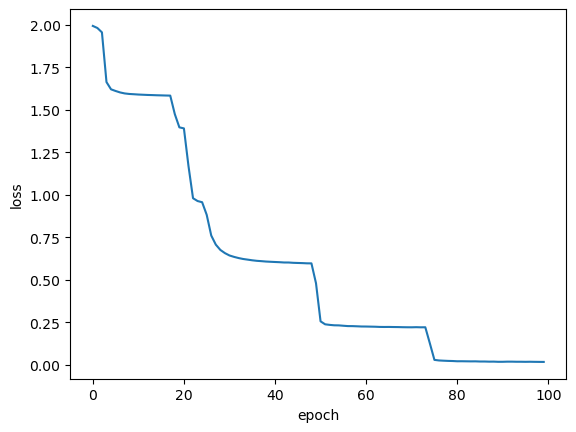

In [3]:
with open("../training_outputs/counting/checkpoint-914100/trainer_state.json") as f:
    obj = json.load(f)

loss = []
for item in obj["log_history"]:
    loss.append(item["loss"])


plt.plot(np.arange(len(loss)), np.array(loss))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

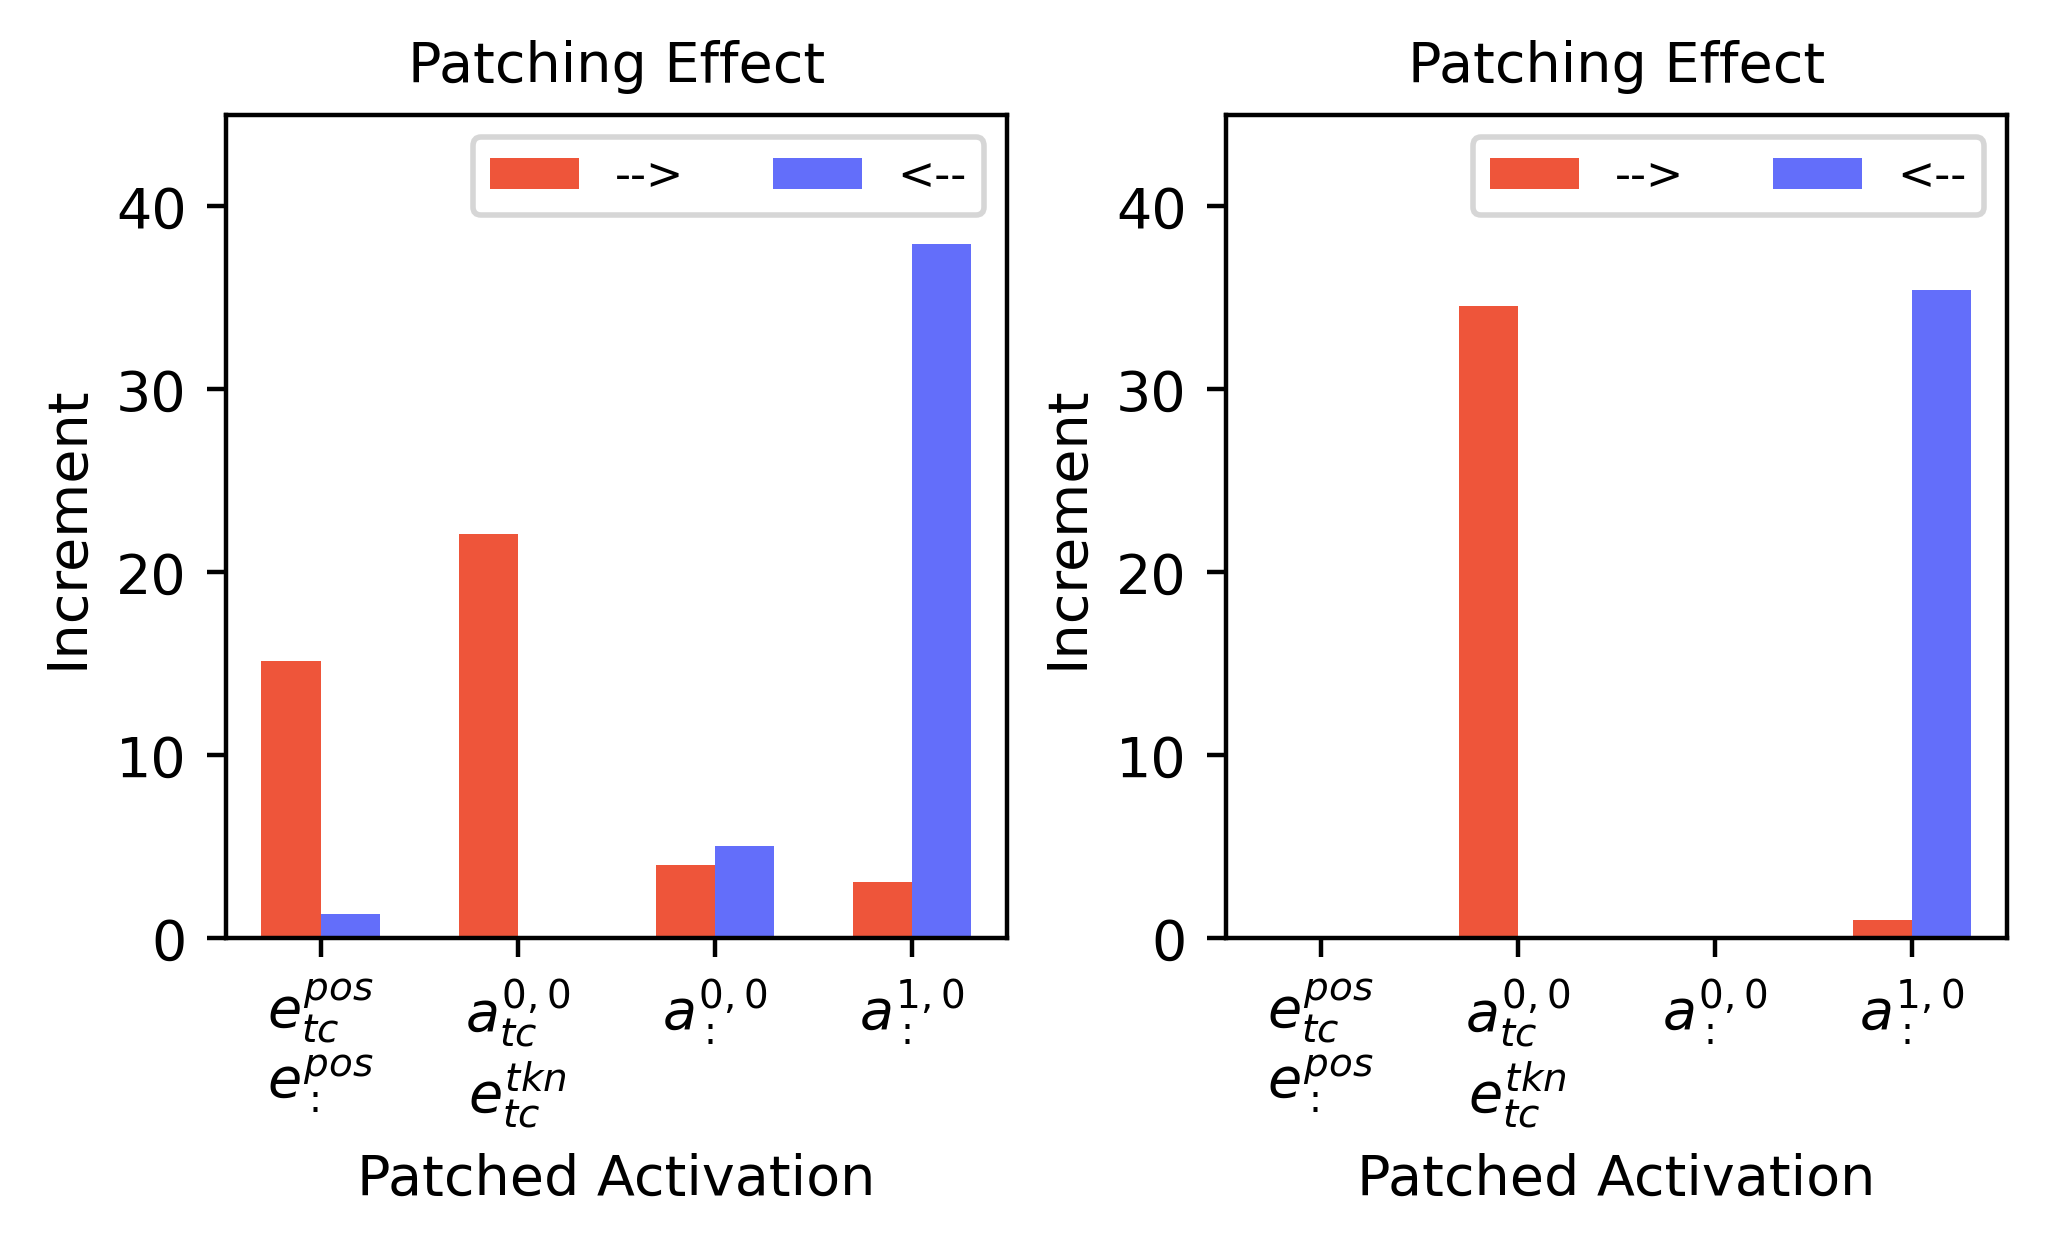

In [34]:
# with open("causal_exp.json") as f:
#     results = json.load(f)

fig, ax = plt.subplots(1, 2, figsize=(5,3), layout='constrained')
fig.set_dpi(400)
width = 0.30

results = {"forward": [15.127565181869116, 37.218477888371396, 41.182994137807995, 44.25053480756711], \
            "backward": [37.941413723207134, 42.94260998848157, 42.94260998848157, 44.25053480756711]}


forward_values = results["forward"]
backward_values = results["backward"]
forward_values.insert(0, 0)
backward_values.insert(0, 0)
forward_values = np.array(forward_values)
forward_values = forward_values[1:] - forward_values[:-1]
backward_values = np.array(backward_values)
backward_values = backward_values[1:] - backward_values[:-1]
backward_values = np.flip(backward_values)


x = np.arange(4)
rects = ax[0].bar(x-width/2, forward_values, width, label="-->", color="#EE553A")
rects = ax[0].bar(x+width/2, backward_values, width, label="<--", color="#636EFA")

ax[0].set_ylabel(r"Increment")  #  of $\Delta LD$
ax[0].set_xlabel("Patched Activation")
ax[0].set_title("Patching Effect", fontsize=10)
ax[0].legend(ncols=2, fontsize=8) #loc="upper right", 
ax[0].set_ylim(0, 45)

head_labels = [r"$e^{pos}_{tc}$"+"\n"+r"$e^{pos}_{:}$", r"$a^{0,0}_{tc}$"+"\n"+r"$e^{tkn}_{tc}$", r"$a^{0,0}_{:}$", r"$a^{1,0}_{:}$"]
ax[0].set_xticks(x, head_labels)


results = {"forward": [0.0, 34.51589613361831, 34.55062738356659, 35.5305911667604], \
        "backward": [35.4282617410221, 35.5377205708684, 35.532123512610454, 35.53392705296929]}


forward_values = results["forward"]
backward_values = results["backward"]
forward_values.insert(0, 0)
backward_values.insert(0, 0)
forward_values = np.array(forward_values)
forward_values = forward_values[1:] - forward_values[:-1]
backward_values = np.array(backward_values)
backward_values = backward_values[1:] - backward_values[:-1]
backward_values = np.flip(backward_values)


x = np.arange(4)
rects = ax[1].bar(x-width/2, forward_values, width, label="-->", color="#EE553A")#color=(254/255, 129/255, 125/255))
rects = ax[1].bar(x+width/2, backward_values, width, label="<--", color="#636EFA") #color=(129/255, 184/255, 223/255))

ax[1].set_ylabel(r"Increment")
ax[1].set_xlabel("Patched Activation")
ax[1].set_title("Patching Effect", fontsize=10)
ax[1].legend(ncols=2, fontsize=8)
ax[1].set_ylim(0, 45)

head_labels = [r"$e^{pos}_{tc}$"+"\n"+r"$e^{pos}_{:}$", r"$a^{0,0}_{tc}$"+"\n"+r"$e^{tkn}_{tc}$", r"$a^{0,0}_{:}$", r"$a^{1,0}_{:}$"]
ax[1].set_xticks(x, head_labels)

# handles, labels = ax[-1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')

plt.show()

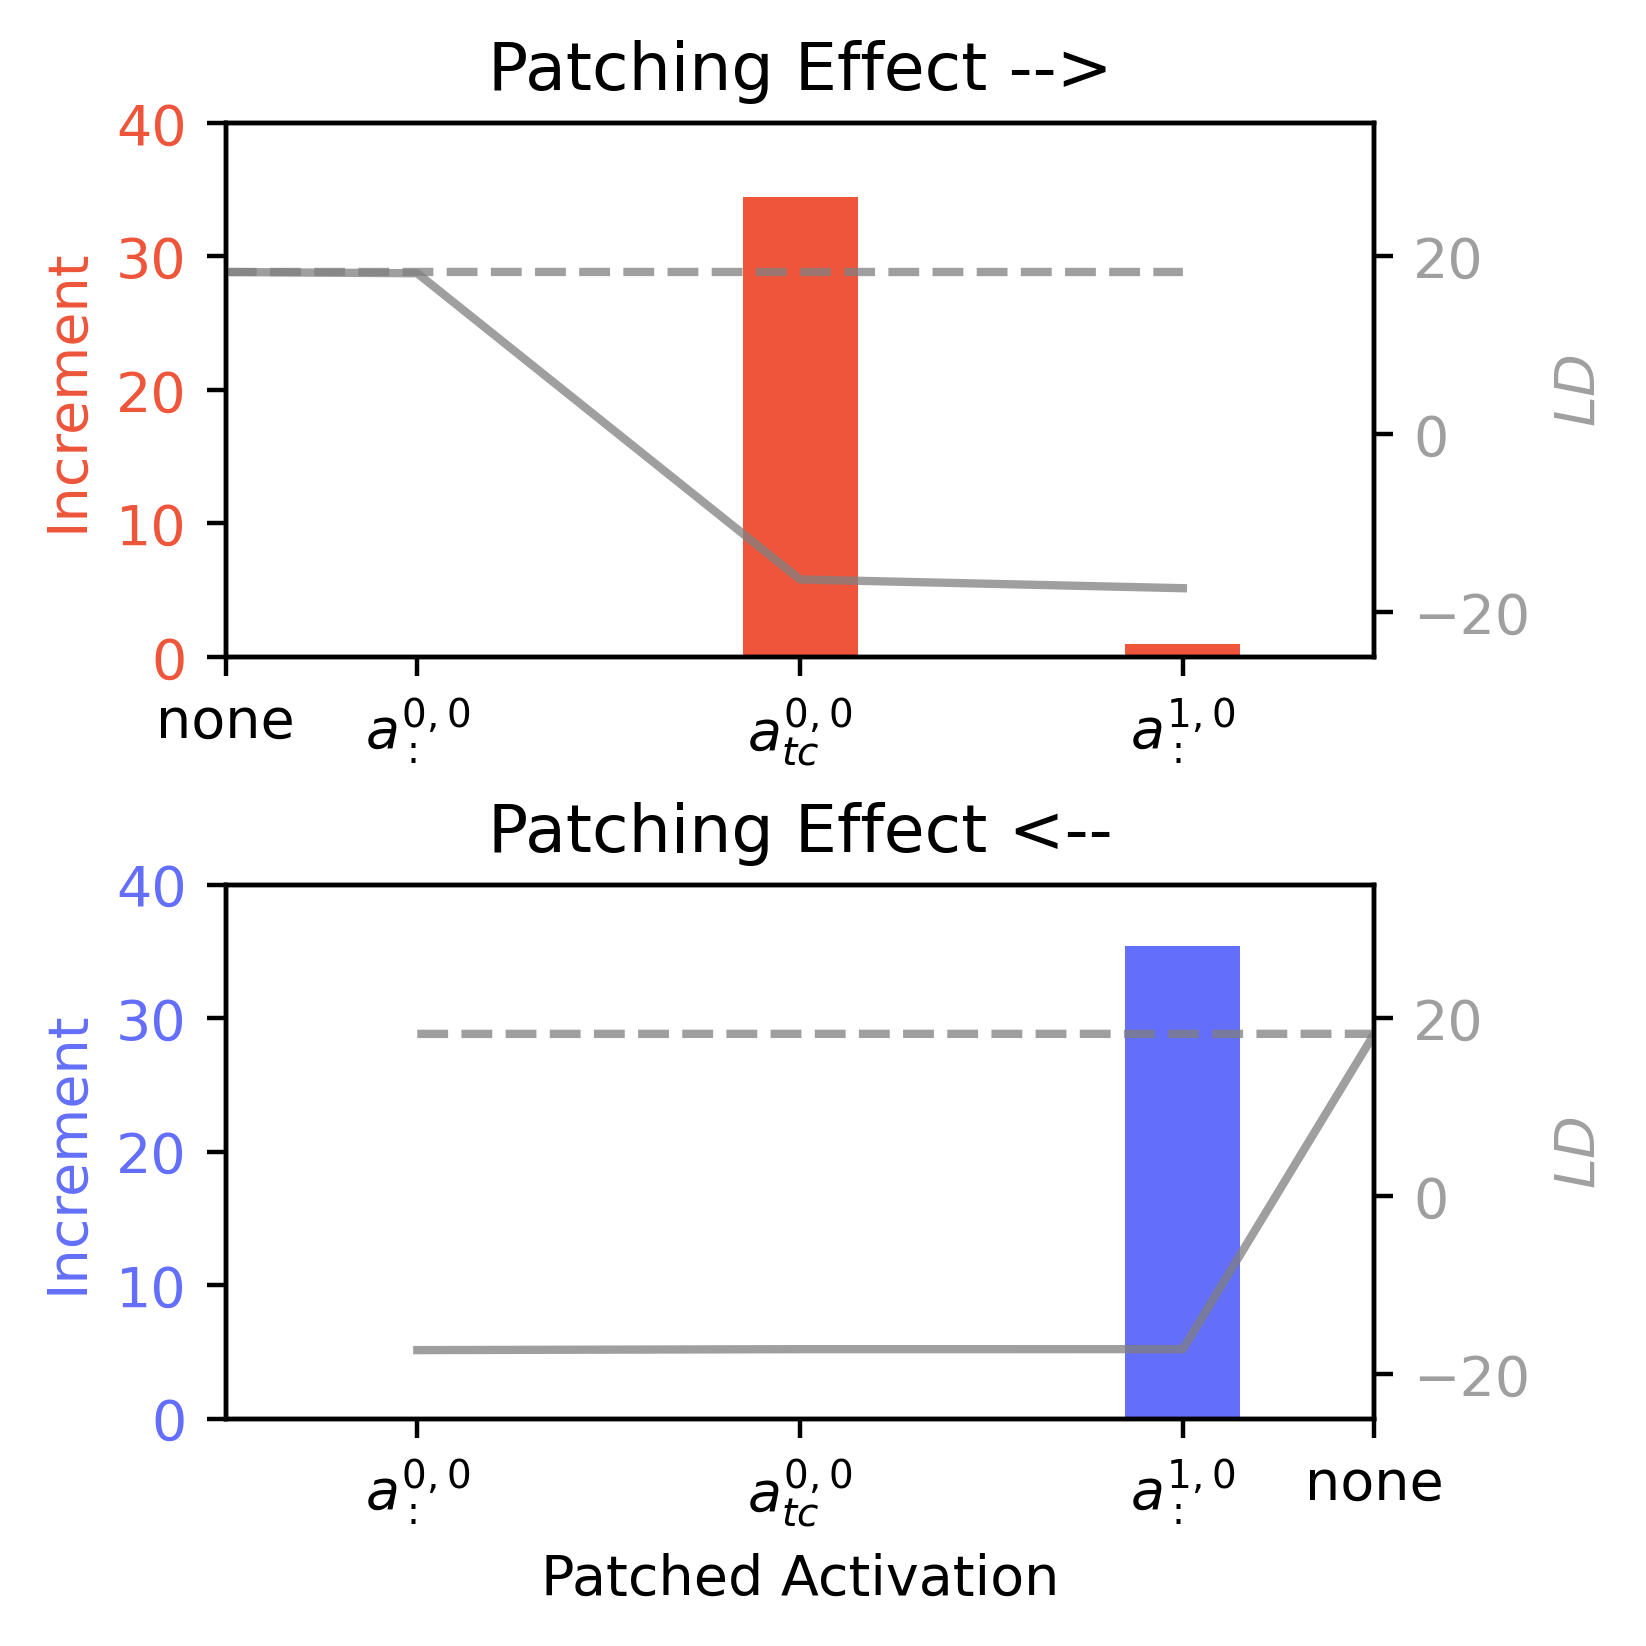

In [16]:
# with open("causal_exp.json") as f:
#     results = json.load(f)

fig, ax = plt.subplots(2, 1, figsize=(4,4), layout='constrained')   # 
fig.set_dpi(400)
width = 0.30

results = {"forward": [0.14948562072094518, 34.55062738356659, 35.5305911667604], \
        "backward": [35.4282617410221, 35.431088127224, 35.532123512610454]}

forward_orig_diff = np.array([18.221216658529357, 18.22876972529598, 18.223079665958085, 18.222514747469248])
forward_patched_diff = np.array([18.221216658529357, 18.079284104575034, -16.327547717608503, -17.308076419291154])

backward_orig_diff = np.array([18.220953584736804, 18.2261600181203, 18.226286422327192, 18.226286422327192])
backward_patched_diff = np.array([-17.311169927873653, -17.204928109103697, -17.20197531869491, 18.226286422327192])


forward_values = results["forward"]
backward_values = results["backward"]
forward_values.insert(0, 0)
backward_values.insert(0, 0)
forward_values = np.array(forward_values)
forward_values = forward_values[1:] - forward_values[:-1]
backward_values = np.array(backward_values)
backward_values = backward_values[1:] - backward_values[:-1]
backward_values = np.flip(backward_values)


x = np.arange(3)+0.5

ax[0].bar(x, forward_values, width, label=r"Incre $(LD_{orig}-LD_{pch})$", color="#EE553A")  # 
# ax[0].set_xlabel("Patched Activation")
ax[0].set_xlim(0, 3)
ax[0].set_ylim(0, 40)
ax[0].set_ylabel(r"Increment", color="#EE553A")
ax[0].tick_params(axis="y", labelcolor="#EE553A")
ax[0].set_title("Patching Effect -->")

color_curve = "#808080C0"
ax_temp = ax[0].twinx()
ax_temp.plot([0,0.5,1.5,2.5], forward_orig_diff, color=color_curve, linestyle="dashed", label=r"$LD_{orig}$")
ax_temp.plot([0,0.5,1.5,2.5], forward_patched_diff, color=color_curve, label=r"$LD_{pch}$")
ax_temp.set_ylabel(r"$LD$", color=color_curve)
ax_temp.set_ylim(-25, 35)
ax_temp.tick_params(axis="y", labelcolor=color_curve)

# lines0, labels0 = ax[0].get_legend_handles_labels()
# lines_temp, labels_temp = ax_temp.get_legend_handles_labels()
# ax[0].legend(lines0+lines_temp, labels0+labels_temp, ncols=3, fontsize=8)

head_labels = ["none", r"$a^{0,0}_{:}$", r"$a^{0,0}_{tc}$", r"$a^{1,0}_{:}$"]
ax[0].set_xticks([0,0.5,1.5,2.5], head_labels) 


ax[1].bar(x, backward_values, width, label=r"Increment of $(LD_{orig}-LD_{pch})$", color="#636EFA")
ax[1].set_xlabel("Patched Activation")
ax[1].set_xlim(0, 3)
ax[1].set_ylim(0, 40)
ax[1].set_ylabel(r"Increment", color="#636EFA")
ax[1].tick_params(axis="y", labelcolor="#636EFA")
ax[1].set_title("Patching Effect <--")

color_curve = "#808080C0"
ax_temp = ax[1].twinx()
ax_temp.plot([0.5,1.5,2.5,3.0], backward_orig_diff, color=color_curve, linestyle="dashed", label=r"$LD_{orig}$")
ax_temp.plot([0.5,1.5,2.5,3.0], backward_patched_diff, color=color_curve, label=r"$LD_{pch}$")
ax_temp.set_ylabel(r"$LD$", color=color_curve)
ax_temp.set_ylim(-25, 35)
ax_temp.tick_params(axis="y", labelcolor=color_curve)

# lines1, labels1 = ax[1].get_legend_handles_labels()
# lines_temp, labels_temp = ax_temp.get_legend_handles_labels()
# ax[1].legend(lines1+lines_temp, labels1+labels_temp, ncols=3, fontsize=8, loc=(0,5))

# ax[0].set_ylim(0, 45)

# head_labels = [r"$e^p_{qc},e^p_{:}$", r"$a^{0,0}_{qc},e^t_{qc}$", r"$a^{0,0}_{:}$", r"$a^{1,0}_{:}$"]
head_labels = [r"$a^{0,0}_{:}$", r"$a^{0,0}_{tc}$", r"$a^{1,0}_{:}$", "none"]
ax[1].set_xticks([0.5,1.5,2.5,3.0], head_labels) 

# fig.legend(lines0+lines_temp[:1]+lines1+lines_temp[1:], labels0+labels_temp[:1]+labels1+labels_temp[1:], ncols=2, fontsize=8, loc="upper center")
# fig.tight_layout()

# handles, labels = ax[-1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')

plt.show()

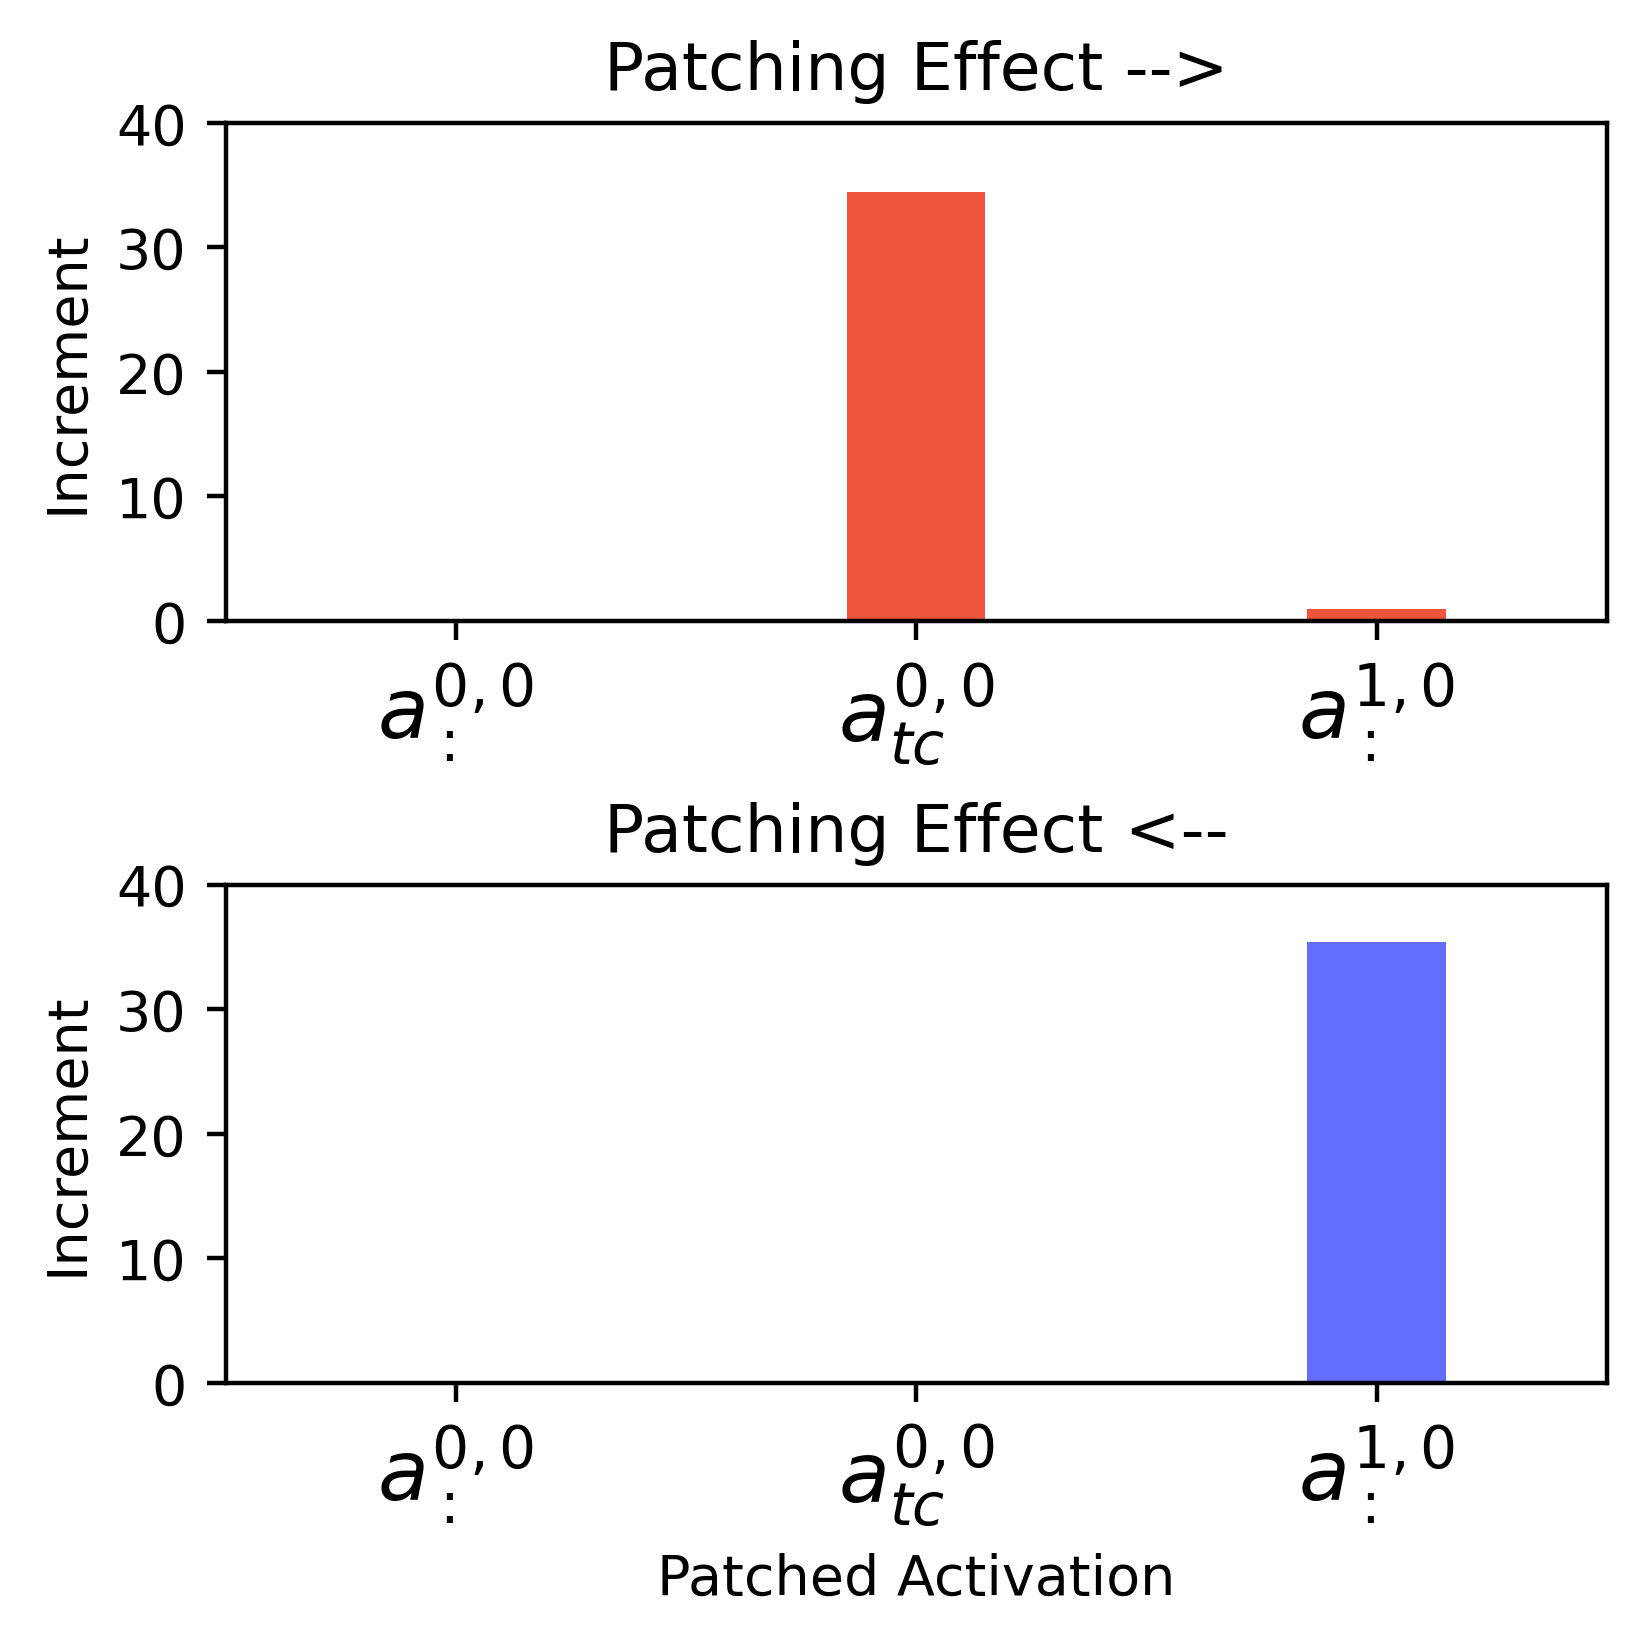

In [9]:
# with open("causal_exp.json") as f:
#     results = json.load(f)

fig, ax = plt.subplots(2, 1, figsize=(4,4), layout='constrained')   # 
fig.set_dpi(400)
width = 0.30

results = {"forward": [0.14948562072094518, 34.55062738356659, 35.5305911667604], \
        "backward": [35.4282617410221, 35.431088127224, 35.532123512610454]}

forward_orig_diff = np.array([18.221216658529357, 18.22876972529598, 18.223079665958085, 18.222514747469248])
forward_patched_diff = np.array([18.221216658529357, 18.079284104575034, -16.327547717608503, -17.308076419291154])

backward_orig_diff = np.array([18.220953584736804, 18.2261600181203, 18.226286422327192, 18.226286422327192])
backward_patched_diff = np.array([-17.311169927873653, -17.204928109103697, -17.20197531869491, 18.226286422327192])


forward_values = results["forward"]
backward_values = results["backward"]
forward_values.insert(0, 0)
backward_values.insert(0, 0)
forward_values = np.array(forward_values)
forward_values = forward_values[1:] - forward_values[:-1]
backward_values = np.array(backward_values)
backward_values = backward_values[1:] - backward_values[:-1]
backward_values = np.flip(backward_values)


x = np.arange(3)+0.5

ax[0].bar(x, forward_values, width, label=r"Incre $(LD_{orig}-LD_{pch})$", color="#EE553A")  # 
# ax[0].set_xlabel("Patched Activation")
ax[0].set_xlim(0, 3)
ax[0].set_ylim(0, 40)
ax[0].set_ylabel(r"Increment")
ax[0].set_title("Patching Effect -->")

# color_curve = "#808080C0"
# ax_temp = ax[0].twinx()
# ax_temp.plot([0,0.5,1.5,2.5], forward_orig_diff, color=color_curve, linestyle="dashed", label=r"$LD_{orig}$")
# ax_temp.plot([0,0.5,1.5,2.5], forward_patched_diff, color=color_curve, label=r"$LD_{pch}$")
# ax_temp.set_ylabel(r"$LD$", color=color_curve)
# ax_temp.set_ylim(-25, 35)
# ax_temp.tick_params(axis="y", labelcolor=color_curve)

# lines0, labels0 = ax[0].get_legend_handles_labels()
# lines_temp, labels_temp = ax_temp.get_legend_handles_labels()
# ax[0].legend(lines0+lines_temp, labels0+labels_temp, ncols=3, fontsize=8)

head_labels = [r"$a^{0,0}_{:}$", r"$a^{0,0}_{tc}$", r"$a^{1,0}_{:}$"]
ax[0].set_xticks([0.5,1.5,2.5], head_labels, fontsize=15) 


ax[1].bar(x, backward_values, width, label=r"Increment of $(LD_{orig}-LD_{pch})$", color="#636EFA")
ax[1].set_xlabel("Patched Activation")
ax[1].set_xlim(0, 3)
ax[1].set_ylim(0, 40)
ax[1].set_ylabel(r"Increment")
ax[1].set_title("Patching Effect <--")

# color_curve = "#808080C0"
# ax_temp = ax[1].twinx()
# ax_temp.plot([0.5,1.5,2.5,3.0], backward_orig_diff, color=color_curve, linestyle="dashed", label=r"$LD_{orig}$")
# ax_temp.plot([0.5,1.5,2.5,3.0], backward_patched_diff, color=color_curve, label=r"$LD_{pch}$")
# ax_temp.set_ylabel(r"$LD$", color=color_curve)
# ax_temp.set_ylim(-25, 35)
# ax_temp.tick_params(axis="y", labelcolor=color_curve)

# lines1, labels1 = ax[1].get_legend_handles_labels()
# lines_temp, labels_temp = ax_temp.get_legend_handles_labels()
# ax[1].legend(lines1+lines_temp, labels1+labels_temp, ncols=3, fontsize=8, loc=(0,5))

# ax[0].set_ylim(0, 45)

# head_labels = [r"$e^p_{qc},e^p_{:}$", r"$a^{0,0}_{qc},e^t_{qc}$", r"$a^{0,0}_{:}$", r"$a^{1,0}_{:}$"]
head_labels = [r"$a^{0,0}_{:}$", r"$a^{0,0}_{tc}$", r"$a^{1,0}_{:}$"]
ax[1].set_xticks([0.5,1.5,2.5], head_labels, fontsize=15) 

# fig.legend(lines0+lines_temp[:1]+lines1+lines_temp[1:], labels0+labels_temp[:1]+labels1+labels_temp[1:], ncols=2, fontsize=8, loc="upper center")
# fig.tight_layout()

# handles, labels = ax[-1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')

plt.show()